In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.metrics import roc_curve, auc
from rdkit import Chem
from matplotlib.cm import viridis
from matplotlib.colors import Normalize

matplotlib.rcdefaults()
sns.set_style("darkgrid")
plt.rcParams["figure.dpi"] = 100

pd.set_option("display.max_columns", None)

In [2]:
# title suffix
title_suffix = "GPR40"

# Files we are processing
file_path_sdf_active = "./GPR40/docking/GPR40_active_docking_lib_sorted.sdf"
file_path_sdf_decoy = "./GPR40/docking/GPR40_decoy_docking_lib_sorted.sdf"
file_path_strain_active = "./GPR40/strain/GPR40_active_docking_lib_sorted.csv"
file_path_strain_decoy = "./GPR40/strain/GPR40_decoy_docking_lib_sorted.csv"

In [3]:
# Parameters
title_suffix = "OPRD"
file_path_sdf_active = "./OPRD/docking/OPRD_active_docking_lib_sorted.sdf"
file_path_sdf_decoy = "./OPRD/docking/OPRD_decoy_docking_lib_sorted.sdf"
file_path_strain_active = "./OPRD/strain/OPRD_active_docking_lib_sorted.csv"
file_path_strain_decoy = "./OPRD/strain/OPRD_decoy_docking_lib_sorted.csv"


In [4]:
# import matplotx

# plt.style.use(matplotx.styles.tokyo_night["storm"])

In [5]:
def sdf_to_df(args):
    """
    Load molecules and their properties from an SDF file into a DataFrame.

    Example usage: df=sdf_to_df(("./ADRB1/docking/ADRB1_active_docking_lib.sdf", "active"))

    Note that this function was originally intended to be used with the `multiprocessing` module, so the arguments are passed as a tuple.

    Will likely be updated later.

    """
    file, active_status = args  # Unpack the tuple of arguments

    # Create a molecule supplier
    mol_supplier = Chem.MultithreadedSDMolSupplier(file, numWriterThreads=8)

    # Load the molecules and their properties into a list
    molecules = []
    first_mol = True
    for mol in mol_supplier:
        if mol is not None:
            if first_mol:
                # Get properties as dictionary only for the first molecule
                props = mol.GetPropsAsDict()
                keys = props.keys()
                first_mol = False
            else:
                # For the rest of the molecules, get properties directly
                props = {key: mol.GetProp(key) for key in keys if mol.HasProp(key)}

            props["Title"] = mol.GetProp("_Name")
            props["Mol"] = mol
            props["Activity"] = 1 if active_status == "active" else 0
            molecules.append(props)

    # Convert the list into a DataFrame
    df = pd.DataFrame(molecules)

    # Reorder the DataFrame columns
    cols = ["Title", "Mol", "Activity"] + [
        col for col in df.columns if col not in ["Title", "Mol", "Activity"]
    ]
    df = df[cols]
    df = df.rename(columns={"Title": "Molecule_Name"})

    # Convert 'r_i_docking_score' to numeric, coercing errors to NaN
    df["r_i_docking_score"] = pd.to_numeric(df["r_i_docking_score"], errors="coerce")

    # Print 'Molecule_Name' and 'r_i_docking_score' for entries that could not be converted
    non_convertible_entries = df[df["r_i_docking_score"].isna()]
    for _, row in non_convertible_entries.iterrows():
        print(
            f"Molecule_Name: {row['Molecule_Name']}, r_i_docking_score: {row['r_i_docking_score']}"
        )

    # Drop rows with non-convertible 'r_i_docking_score'
    df = df.dropna(subset=["r_i_docking_score"])

    # Convert 'r_i_docking_score' to int64
    df["r_i_docking_score"] = df["r_i_docking_score"].astype("float64")

    return df

In [6]:
active_sdf = sdf_to_df((file_path_sdf_active, "active"))
decoy_sdf = sdf_to_df((file_path_sdf_decoy, "inactive"))

In [7]:
#TODO replace with a check for duplicates and sys exit with message
duplicates_actives = active_sdf["Molecule_Name"].duplicated()
print(any(duplicates_actives))
duplicates_decoys = decoy_sdf["Molecule_Name"].duplicated()
print(any(duplicates_decoys))

False
False


In [8]:
# from old code, probably fine but not optimal
def concatenate_csv_files(file_list):
    """
    Concatenates multiple strain CSV files into a single dataframe.
    Only the first five columns are kept for now.

    Args:
        file_list (list): A list of file paths to the CSV files.

    Returns:
        pandas.DataFrame: The concatenated dataframe.

    """
    # Specify the column names
    column_names = [
        "Molecule_Name",
        "Total_E",
        "Lower_Bound",
        "Upper_Bound",
        "Num_Torsion_Patterns",
    ]

    # List to hold dataframes
    df_list = []

    # Loop over each file in the list
    for file in file_list:
        # Import the CSV file as a df, using only the first five columns of the CSV file
        df = pd.read_csv(file, usecols=range(5), names=column_names, header=0)
        df_list.append(df)

    # Concatenate all dataframes in the list
    final_df = pd.concat(df_list, ignore_index=True)

    return final_df

In [9]:
active_strain = concatenate_csv_files([file_path_strain_active])
decoy_strain = concatenate_csv_files([file_path_strain_decoy])

In [10]:
#TODO replace with a check for duplicates and sys exit with message
duplicates_actives = active_strain["Molecule_Name"].duplicated()
print(any(duplicates_actives))
duplicates_decoys = decoy_strain["Molecule_Name"].duplicated()
print(any(duplicates_decoys))

False
False


In [11]:
# only keep as commented for debug
# pre_merge = [active_sdf, decoy_sdf, active_strain, decoy_strain]

# for df in pre_merge:
#     print(df.shape)

In [12]:
active_data=pd.merge(active_sdf, active_strain, on='Molecule_Name')
decoy_data=pd.merge(decoy_sdf, decoy_strain, on='Molecule_Name')

In [13]:
# #only keep as commented for debug
# post_merge = [active_data, decoy_data]

# for df in post_merge:
#     print(df.shape)

In [14]:
all_data = pd.concat([active_data, decoy_data])

#print(all_data.shape)

In [15]:
def plot_density(df, title_suffix):
  # Hardcoded column names
  activity_col = 'Activity'
  score_col = 'r_i_docking_score'

  # Create a density plot for the score of active and inactive molecules
  sns.kdeplot(df.loc[df[activity_col] == 0, score_col], label='Inactive', fill=True)
  sns.kdeplot(df.loc[df[activity_col] == 1, score_col], label='Active', fill=True)

  # Add title and labels
  plt.title(f'Density Plot of Docking Score for Active and Decoy Molecules ({title_suffix})')
  plt.xlabel('Docking Score')
  plt.ylabel('Density')
  plt.legend(loc='best')

  # Show the plot
  plt.show()

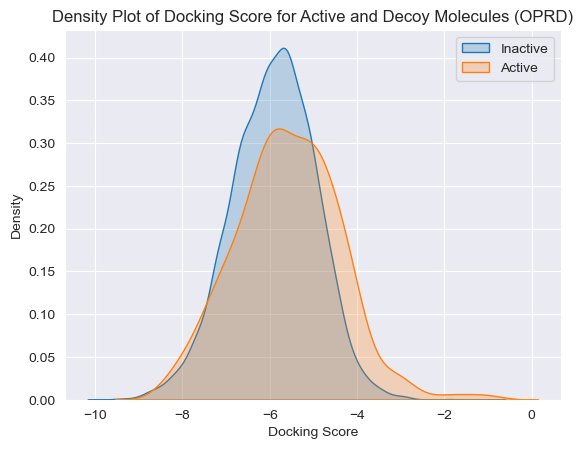

In [16]:
plot_density(all_data, title_suffix)

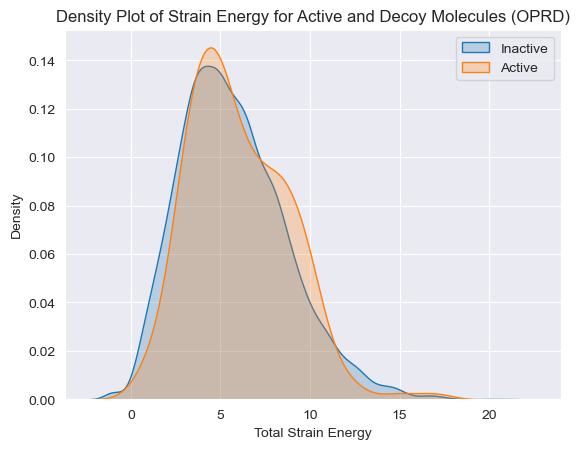

In [17]:
def plot_density_strain(df, title_suffix):
    # Hardcoded column names
    activity_col = "Activity"
    score_col = "Total_E"

    # Create a density plot for the score of active and inactive molecules
    sns.kdeplot(df.loc[df[activity_col] == 0, score_col], label="Inactive", fill=True)
    sns.kdeplot(df.loc[df[activity_col] == 1, score_col], label="Active", fill=True)

    # Add title and labels
    plt.title(
        f"Density Plot of Strain Energy for Active and Decoy Molecules ({title_suffix})"
    )
    plt.xlabel("Total Strain Energy")
    plt.ylabel("Density")
    plt.legend(loc="best")

    # Show the plot
    plt.show()

plot_density_strain(all_data, title_suffix)

In [18]:
def calculate_enrichment_parameters(df):
    """
    Calculates parameters we will need for Enrichment Plots

    Parameters:
    df (pandas.DataFrame): The dataframe to calculate the logAUC for.

    Returns:
    pandas.DataFrame: The dataframe with the logAUC calculated.
    """
    # Sort the subset by 'r_i_docking_score' in ascending order

    df = df.copy()

    df.sort_values(by="r_i_docking_score", inplace=True)

    # Reset the index so that we are ranking by the docking score
    df.reset_index(drop=True, inplace=True)

    # Adjusting the index to start from 1
    df.index += 1

    # Calculate the cumulative sum of active compounds
    df["Cumulative_Actives"] = df["Activity"].cumsum()

    # Calculate the Total Actives
    df["Total_Actives"] = df["Activity"].sum()

    # Calculate the fraction of identified actives at each row
    df["Fraction_Actives"] = df["Cumulative_Actives"] / df["Total_Actives"]

    # Calculate the percentage of compounds screened at each row
    df["Percentage_Screened"] = df.index / len(df)

    return df

In [19]:
all_data = calculate_enrichment_parameters(all_data)
all_data

,Molecule_Name,Mol,Activity,s_m_source_file,i_m_source_file_index,i_lp_mmshare_version,i_f3d_flags,s_lp_Force_Field,r_lp_Energy,b_lp_Chiralities_Consistent,s_lp_Variant,s_i_glide_gridfile,i_i_glide_lignum,i_i_glide_rotatable_bonds,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_hbond,r_i_glide_metal,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_erotb,r_i_glide_esite,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum,r_i_glide_eff_state_penalty,Total_E,Lower_Bound,Upper_Bound,Num_Torsion_Patterns,Cumulative_Actives,Total_Actives,Fraction_Actives,Percentage_Screened
1,C39933632_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x176c2e650>,0,OPRD_chembl19_set_decoy_sc.smi,2097,53161,0,S-OPLS,59.2362,1,C39933632_Isomer1-1,OPRD,2096,6,-9.71214,-0.303504,-0.963567,-2.17481,-9.71214,-3.40649,-0.339259,-0,-2.16181,-43.9798,-12.072,0.426867,-0.221657,-92.6984,-56.0518,9.16763,118,350,0,6.083277,4.752726,NaN,2.0,0,185,0.000000,0.000107
2,C39915987_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x176c2e730>,0,OPRD_chembl19_set_decoy_sc.smi,3261,53161,0,S-OPLS,32.8166,1,C39915987_Isomer1-1,OPRD,3259,11,-9.48897,-0.306096,-0.961563,-2.14005,-9.48897,-2.79745,-0.258864,-0,-1.31523,-36.7735,-23.1726,0.387183,-0.190042,-96.5286,-59.9461,10.8189,206,356,0,11.804649,9.901872,NaN,6.0,0,185,0.000000,0.000215
3,C39231640_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x176c2e6c0>,0,OPRD_chembl19_set_decoy_sc.smi,7261,53161,0,S-OPLS,43.3081,1,C39231640_Isomer1-1,OPRD,7258,4,-9.45578,-0.326061,-1.00176,-2.16513,-9.45578,-1.59024,-0.35497,-0,-2.75052,-47.8029,-16.7426,0.382212,-0.240731,-101.475,-64.5454,5.64371,2,192,0,6.667439,5.525186,NaN,0.0,0,185,0.000000,0.000322
4,C39915953_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x176c2e880>,0,OPRD_chembl19_set_decoy_sc.smi,7805,53161,0,S-OPLS,43.2058,1,C39915953_Isomer1-1,OPRD,7802,10,-9.39112,-0.276209,-0.894811,-2.07476,-9.39112,-3.15139,-0.240971,-0,-1.24306,-38.7002,-19.5618,0.335635,-0.222046,-94.125,-58.262,6.52834,80,241,0,4.919639,4.081011,6.779628,3.0,0,185,0.000000,0.000430
5,C63439904_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x176c2e810>,0,OPRD_chembl19_set_decoy_sc.smi,8720,53161,0,S-OPLS,26.7144,1,C63439904_Isomer1-1,OPRD,8717,6,-9.33877,-0.359183,-1.06408,-2.19318,-9.33877,-2.47585,-0.444088,-0,-2.86174,-35.0463,-13.501,0.409568,-0.189195,-74.9676,-48.5474,8.10222,6,242,0,6.619291,5.619678,NaN,1.0,0,185,0.000000,0.000537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9300,CHEMBL2442643_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x176c2e500>,1,OPRD_chembl19_set_active_sc.smi,101,53161,0,S-OPLS,5.48966,1,CHEMBL2442643_Isomer1-1,OPRD,100,10,-1.88591,-0.0898054,-0.247766,-0.466288,-1.88591,-1.71726,-0.111248,-0,-1.72387,-26.0114,-3.30782,3.47733,-0.0141234,-28.4164,-29.3193,8.67692,202,221,0,16.952461,14.078733,NaN,7.0,184,185,0.994595,0.999570
9301,C02885631_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x29c759e70>,0,OPRD_chembl19_set_decoy_sc.smi,8866,53161,0,S-OPLS,20.9216,1,C02885631_Isomer1-1,OPRD,8863,9,-1.83514,-0.0834157,-0.233734,-0.448576,-1.83514,-1.88738,-0.0649975,-0,-1.77441,-30.0686,-2.09367,3.70912,0,-33.8595,-32.1623,4.12401,260,283,0,14.761346,12.371574,NaN,1.0,184,185,0.994595,0.999678
9302,C71778294_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x29c759ee0>,0,OPRD_chembl19_set_decoy_sc.smi,8902,53161,0,S-OPLS,2.89653,1,C71778294_Isomer1-1,OPRD,8899,11,-1.82032,-0.101129,-0.265033,-0.467904,-1.82032,-2.66741,0,-0,-1.84958,-31.4247,-0.694825,4.37213,0,-32.2376,-32.1195,6.58747,371,345,0,13.266088,10.861073,NaN,7.0,184,185,0.994595,0.999785
9303,CHEMBL611160_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x176c2e5e0>,1,OPRD_chembl19_set_active_sc.smi,55,53161,0,S-OPLS,65.4226,1,CHEMBL611160_Isomer1-1,OPRD,54,9,-1.09723,-0.0353945,-0.111188,-0.2474

In [20]:
total_e_thresholds = [None, 4, 4.5, 5.0, 5.5, 6.0, 7.0, 7.5, 8.0]

In [21]:
def logauc_by_strain(df, a=1e-3, total_e_threshold=None):
    # Filter dataframe based on 'Total_E' threshold if provided
    if total_e_threshold is not None:
        df = df[df["Total_E"] <= total_e_threshold]

    # Invert scores since lower scores indicate positive class
    y_scores_inverted = -df["r_i_docking_score"]

    # Calculate FPR, TPR, and thresholds using sklearn
    fpr, tpr, _ = roc_curve(df["Activity"], y_scores_inverted)

    # Select the thresholds that result in FPR >= a for log scale plotting
    valid_indices = np.where(fpr >= a)
    fpr_valid = fpr[valid_indices]
    tpr_valid = tpr[valid_indices]

    # Calculate log of FPR for valid indices
    log_fpr_valid = np.log10(fpr_valid)

    # Calculate the AUC for the valid range
    linlog_auc = auc(log_fpr_valid, tpr_valid)

    ### NOTE TIMES 10 NOTE ###
    log_auc = (linlog_auc / -np.log10(a)) * 10

    return log_auc

In [22]:
def plot_log_aucs(data, thresholds, title_suffix):
    # Calculate log_auc for each threshold and plot
    log_aucs = [logauc_by_strain(data, total_e_threshold=t) for t in thresholds]
    
    # Create labels for the x-axis
    x_labels = [str(t) if t is not None else 'No Cutoff' for t in thresholds]
    
    plt.bar(range(len(thresholds)), log_aucs, tick_label=x_labels)
    plt.title(f"Linear Log10 AUC by Strain Energy Cutoff ({title_suffix})")
    plt.xlabel("Strain Energy Cutoff")
    plt.ylabel("Linear Log10 AUC (x10)")
    plt.show()

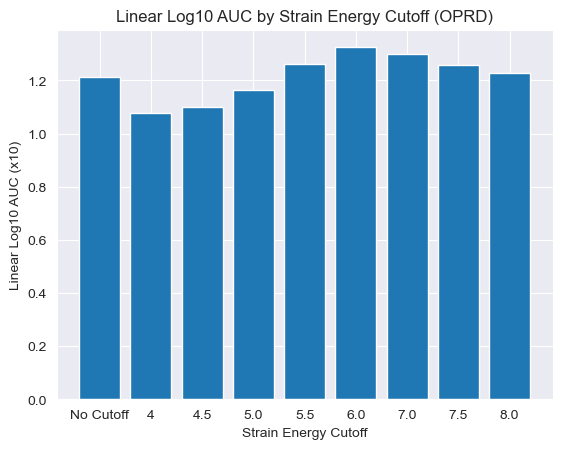

In [23]:
plot_log_aucs(all_data, total_e_thresholds, title_suffix)

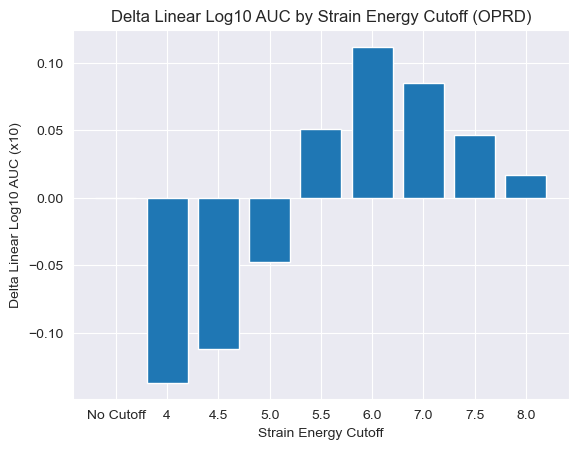

In [24]:
def plot_delta_log_aucs(data, thresholds, title_suffix):
  # Calculate log_auc for 'None' threshold
  none_log_auc = logauc_by_strain(data, total_e_threshold=None)
  
  # Calculate delta log_auc for each threshold and plot
  delta_log_aucs = [logauc_by_strain(data, total_e_threshold=t) - none_log_auc for t in thresholds]
  
  # Create labels for the x-axis
  x_labels = [str(t) if t is not None else 'No Cutoff' for t in thresholds]
  
  plt.bar(range(len(thresholds)), delta_log_aucs, tick_label=x_labels)
  plt.title(f"Delta Linear Log10 AUC by Strain Energy Cutoff ({title_suffix})")
  plt.xlabel("Strain Energy Cutoff")
  plt.ylabel("Delta Linear Log10 AUC (x10)")
  plt.show()

plot_delta_log_aucs(all_data, total_e_thresholds, title_suffix)

In [25]:
def write_log_aucs(data, thresholds, title_suffix):
    # Calculate log_auc for each threshold
    log_aucs = [logauc_by_strain(data, total_e_threshold=t) for t in thresholds]

    delta_log_aucs = [0] + [log_aucs[i] - log_aucs[0] for i in range(1, len(log_aucs))]

    # print(f"Delta LogAUCs for {title_suffix}: {delta_log_aucs}")

    # Create labels for the x-axis
    x_labels = [str(t) if t is not None else 'No Cutoff' for t in thresholds]

    # Create a dataframe to hold the data
    df = pd.DataFrame({
        "Protein": title_suffix,
        "Strain Energy Cutoff": x_labels,
        "Linear Log10 AUC (x10)": log_aucs,
        "Delta Linear Log10 AUC (x10)": delta_log_aucs
    })

    # Write the dataframe to a CSV file
    df.to_csv(f"./papermill/csv/strain_log_aucs_{title_suffix}.csv", index=False)

write_log_aucs(all_data, total_e_thresholds, title_suffix)

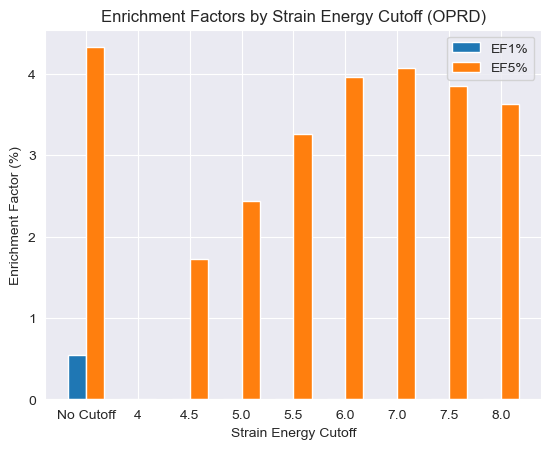

In [26]:
def enrichment_metrics_by_strain(df, total_e_threshold=None):

    if total_e_threshold is not None:
        df = df[df["Total_E"] <= total_e_threshold]

    df = calculate_enrichment_parameters(df).copy()

    closest_to_one_percent = df.iloc[
        (df["Percentage_Screened"] - 0.01).abs().argsort()[:1]
    ]

    ef1 = (
        closest_to_one_percent["Cumulative_Actives"].values[0]
        / closest_to_one_percent["Total_Actives"].values[0]
    ) * 100

    closest_to_five_percent = df.iloc[
        (df["Percentage_Screened"] - 0.05).abs().argsort()[:1]
    ]
    ef5 = (
        closest_to_five_percent["Cumulative_Actives"].values[0]
        / closest_to_five_percent["Total_Actives"].values[0]) * 100

    # print(df.shape)

    # print(
    #     f"1% Closest Cumulative_Actives: {closest_to_one_percent['Cumulative_Actives'].values[0]}"
    # )
    # print(
    #     f"1% Closest Total_Actives: {closest_to_one_percent['Total_Actives'].values[0]}"
    # )
    # print(
    #     f"5% Closest Cumulative_Actives: {closest_to_five_percent['Cumulative_Actives'].values[0]}"
    # )
    # print(
    #     f"5% Closest Total_Actives: {closest_to_five_percent['Total_Actives'].values[0]}"
    # )

    return ef1, ef5


def bar_plot_enrichment_by_strain(data, thresholds, title_suffix):
    # Calculate enrichment for each threshold
    ef1s, ef5s = zip(*[enrichment_metrics_by_strain(data, total_e_threshold=t) for t in thresholds])

    # print(f"EF1% for {title_suffix}: {ef1s}")
    # print(f"EF5% for {title_suffix}: {ef5s}")

    # Create labels for the x-axis
    x_labels = [str(t) if t is not None else 'No Cutoff' for t in thresholds]

    # Create an array with the positions of each bar on the x axis
    x = np.arange(len(x_labels))

    # Set the width of the bars
    bar_width = 0.35

    plt.bar(x - bar_width/2, ef1s, bar_width, label="EF1%")
    plt.bar(x + bar_width/2, ef5s, bar_width, label="EF5%")
    plt.title(f"Enrichment Factors by Strain Energy Cutoff ({title_suffix})")
    plt.xlabel("Strain Energy Cutoff")
    plt.ylabel("Enrichment Factor (%)")
    plt.xticks(x, x_labels)  # Set the position and labels of the xticks
    plt.legend()
    plt.show()

bar_plot_enrichment_by_strain(all_data, total_e_thresholds, title_suffix)

/var/folders/2c/b9b_8fbs13j5zcz4wv9bqqjm0000gn/T/ipykernel_74101/2506411786.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(


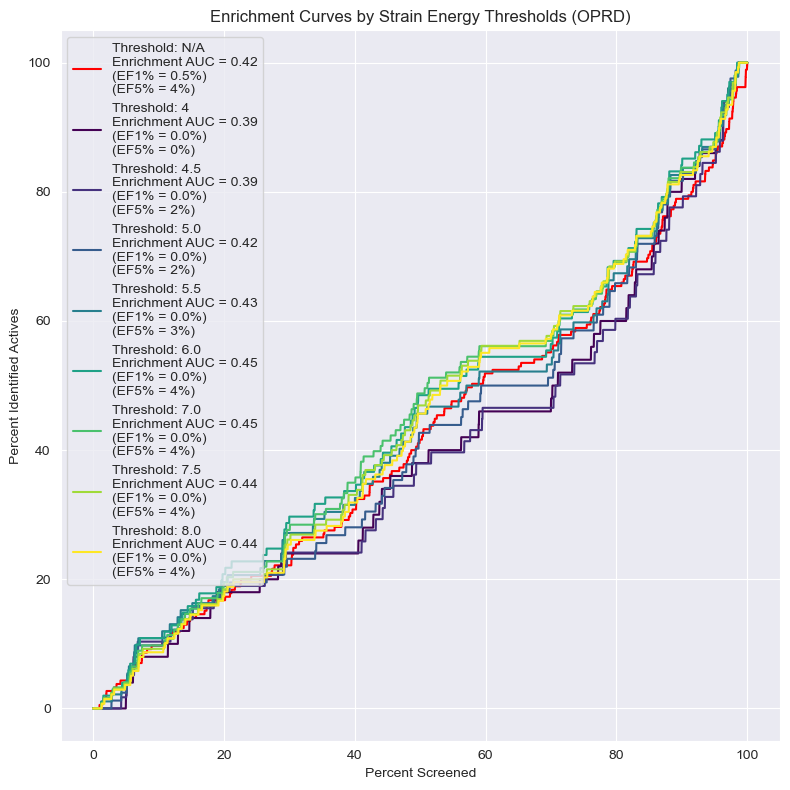

In [27]:
def plot_enrichment_curve_by_strain(df, total_e_threshold=None, ax=None, color='blue'):

    if total_e_threshold is not None:
        df = df[df["Total_E"] <= total_e_threshold]

    df = calculate_enrichment_parameters(df).copy()

    enrichment_auc = auc(df["Percentage_Screened"], df["Fraction_Actives"])

    closest_to_one_percent = df.iloc[
        (df["Percentage_Screened"] - 0.01).abs().argsort()[:1]
    ]

    ef1 = (
        closest_to_one_percent["Cumulative_Actives"].values[0]
        / closest_to_one_percent["Total_Actives"].values[0]
    ) * 100

    closest_to_five_percent = df.iloc[
        (df["Percentage_Screened"] - 0.05).abs().argsort()[:1]
    ]
    ef5 = (
        closest_to_five_percent["Cumulative_Actives"].values[0]
        / closest_to_five_percent["Total_Actives"].values[0]
    ) * 100

    # Plot the enrichment curve
    ax.plot(
        df["Percentage_Screened"] * 100,
        df["Fraction_Actives"] * 100,
        label="Threshold: {}\nEnrichment AUC = {:.2f}\n(EF1% = {:.1f}%)\n(EF5% = {:.0f}%)".format(
            total_e_threshold if total_e_threshold is not None else 'N/A',
            enrichment_auc, ef1, ef5
            ),
        color=color
        )

    # # Add axis labels and title
    # plt.xlabel("Compounds Screened (%)")
    # plt.ylabel("Percent of Identified Actives (%)")
    # plt.title(f"Enrichment Curve ({title_suffix})")

    ax.legend()


def plot_enrichment_all_thresholds(data, thresholds, title_suffix):
    # Create a single plot
    fig, ax = plt.subplots(
        figsize=(8, 8)
        )

    # Define a colormap
    cmap = cm.get_cmap(
        "viridis", len(thresholds) - 1
    )  # Subtract 1 because the first color is manually set

    # Plot semi-log ROC curve for each threshold
    for i, t in enumerate(thresholds):
        # Filter dataframe based on 'Total_E' threshold
        df_filtered = data if t is None else data[data["Total_E"] <= t]

        # Set a distinct color for the first threshold
        color = (
            "red" if t is None else cmap(i - 1)
        )  # Subtract 1 because the first color is manually set

        # Call the function with the filtered data
        plot_enrichment_curve_by_strain(df_filtered, total_e_threshold=t, ax=ax, color=color)

    ax.set_title(f"Enrichment Curves by Strain Energy Thresholds ({title_suffix})")
    ax.set_xlabel("Percent Screened")
    ax.set_ylabel("Percent Identified Actives")

    plt.tight_layout()
    plt.show()

plot = plot_enrichment_all_thresholds(all_data, total_e_thresholds, title_suffix)

In [28]:
def write_enrichment_metrics(data, thresholds, title_suffix):
    # Calculate enrichment for each threshold
    ef1s, ef5s = zip(*[enrichment_metrics_by_strain(data, total_e_threshold=t) for t in thresholds])

    # Create labels for the x-axis
    x_labels = [str(t) if t is not None else 'No Cutoff' for t in thresholds]

    # Create a dataframe to hold the data
    df = pd.DataFrame({
        "Protein": title_suffix,
        "Strain Energy Cutoff": x_labels,
        "EF1%": ef1s,
        "EF5%": ef5s
    })

    print(f"Writing CSV to strain_enrichment_metrics_{title_suffix}.csv")
    df.to_csv(f"./papermill/csv/strain_enrichment_metrics_{title_suffix}.csv", index=False)
    print("CSV writing complete.")

    try:
        df.to_csv(
            f"./papermill/csv/strain_enrichment_metrics_{title_suffix}.csv", index=False
        )
        print("CSV writing complete.")
    except Exception as e:
        print(f"Failed to write CSV: {e}")

write_enrichment_metrics(all_data, total_e_thresholds, title_suffix)

Writing CSV to strain_enrichment_metrics_OPRD.csv
CSV writing complete.
CSV writing complete.


In [29]:
def plot_semi_log_roc(df, a=1e-3, total_e_threshold=None, ax=None, color='blue'):
  # Filter dataframe based on 'Total_E' threshold if provided
  if total_e_threshold is not None:
    df = df[df["Total_E"] <= total_e_threshold]

  # Invert scores since lower scores indicate positive class
  y_scores_inverted = -df["r_i_docking_score"]

  # Calculate FPR, TPR, and thresholds using sklearn
  fpr, tpr, _ = roc_curve(df["Activity"], y_scores_inverted)

  # Select the thresholds that result in FPR >= a for log scale plotting
  valid_indices = np.where(fpr >= a)
  fpr_valid = fpr[valid_indices]
  tpr_valid = tpr[valid_indices]

  # Calculate log of FPR for valid indices
  log_fpr_valid = np.log10(fpr_valid)

  # Calculate LogAUC
  log_auc = (auc(log_fpr_valid, tpr_valid) / -np.log10(a)) * 10

  # Count the number of rows with Activity = 1 and the total number of rows
  activity_1_count = df[df["Activity"] == 1].shape[0]
  total_count = df.shape[0]

  # Plot semi-log ROC curve
  ax.plot(
    log_fpr_valid,
    tpr_valid,
    label=f"Threshold: {total_e_threshold if total_e_threshold is not None else 'N/A'}, LogAUC: {log_auc:.2f}, Actives: {activity_1_count}, Total count: {total_count}",
    color=color
  )
  ax.legend()


In [30]:
def plot_all_thresholds(data, thresholds, title_suffix):
    # Create a single plot
    fig, ax = plt.subplots(figsize=(10, 10))

    # Define a colormap
    cmap = cm.get_cmap('viridis', len(thresholds) - 1)  # Subtract 1 because the first color is manually set

    # Plot semi-log ROC curve for each threshold
    for i, t in enumerate(thresholds):
        # Filter dataframe based on 'Total_E' threshold
        df_filtered = data if t is None else data[data["Total_E"] <= t]

        # Set a distinct color for the first threshold
        color = 'red' if t is None else cmap(i - 1)  # Subtract 1 because the first color is manually set

        # Call the function with the filtered data
        plot_semi_log_roc(df_filtered, total_e_threshold=t, ax=ax, color=color)

    ax.set_title(f"Strain Energy Thresholds ({title_suffix})")
    ax.set_xlabel("log(FPR)")
    ax.set_ylabel("TPR")

    plt.tight_layout()
    plt.show()

/var/folders/2c/b9b_8fbs13j5zcz4wv9bqqjm0000gn/T/ipykernel_74101/2145919082.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', len(thresholds) - 1)  # Subtract 1 because the first color is manually set


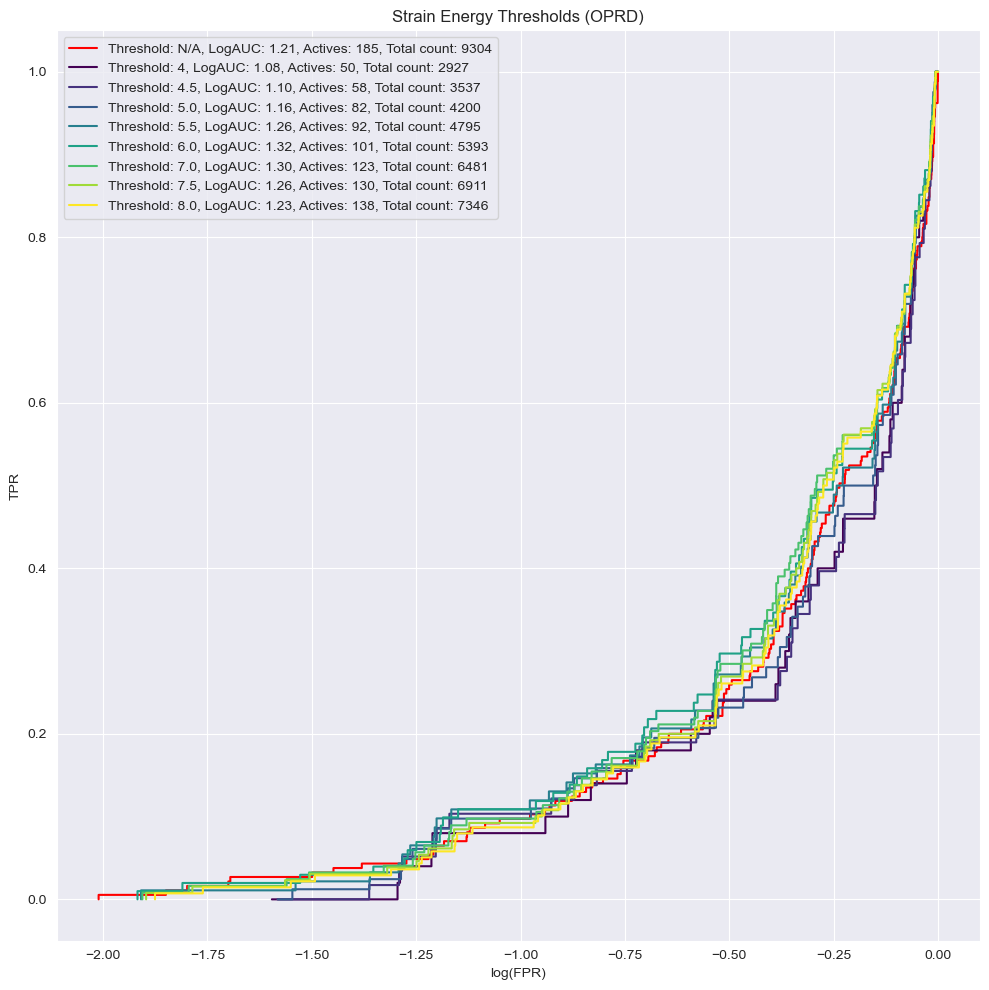

In [31]:
plot = plot_all_thresholds(all_data, total_e_thresholds, title_suffix)

/var/folders/2c/b9b_8fbs13j5zcz4wv9bqqjm0000gn/T/ipykernel_74101/2191446731.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', len(thresholds) - 1)  # Subtract 1 because the first color is manually set


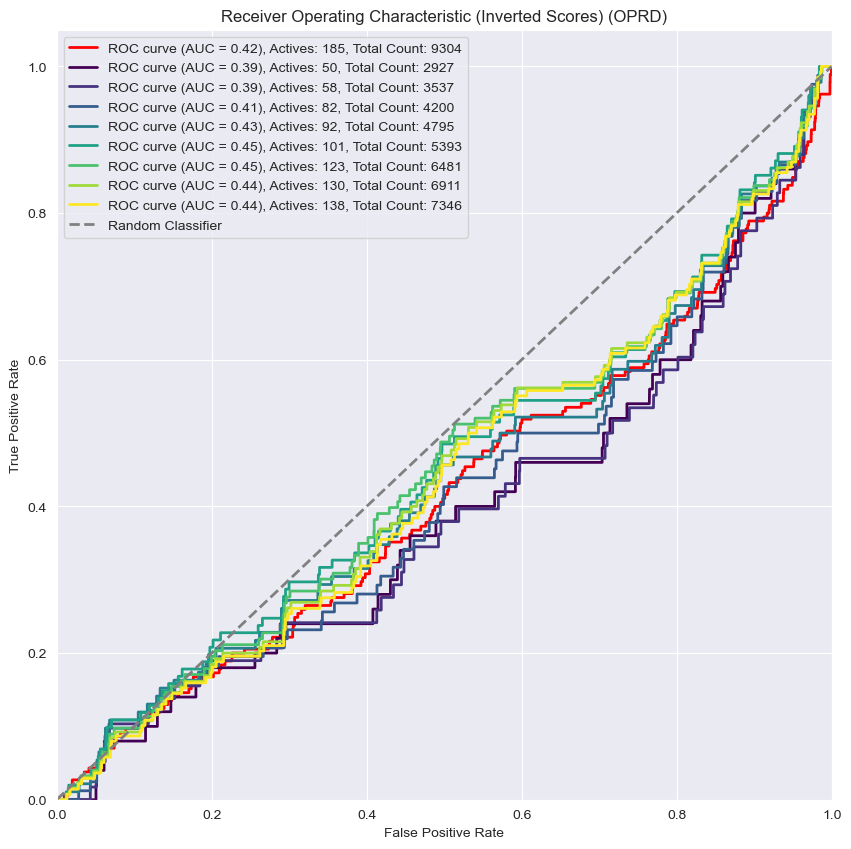

In [32]:
def plot_roc_curve_inverted(data, total_e_threshold, ax, title_suffix, color='blue'):
    """
    Plot the ROC curve for the given true labels and inverted scores.

    :param data: The DataFrame containing the data.
    :param total_e_threshold: The threshold for the 'Total_E' column. If this is not None, the data is filtered to only include rows where 'Total_E' is less than or equal to this threshold.
    :param ax: The axes object to plot on.
    :param title_suffix: The suffix to add to the title of the plot.
    :param color: The color to use for the ROC curve.
    """
    # Filter the data based on 'Total_E' threshold
    df = data if total_e_threshold is None else data[data["Total_E"] <= total_e_threshold]

    # Get the true labels and scores
    y_true = df["Activity"]
    y_scores = df["r_i_docking_score"]

    # Inverting the scores
    y_scores_inverted = -y_scores

    # Compute the ROC curve and AUC with inverted scores
    fpr, tpr, thresholds = roc_curve(y_true, y_scores_inverted)
    roc_auc = auc(fpr, tpr)

    # Count the number of rows with Activity = 1 and the total number of rows
    activity_1_count = df[df["Activity"] == 1].shape[0]
    total_count = df.shape[0]

    # Plotting the ROC curve
    ax.plot(fpr, tpr, lw=2, label=f"ROC curve (AUC = {roc_auc:.2f}), Actives: {activity_1_count}, Total Count: {total_count}", color=color)

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f"Receiver Operating Characteristic (Inverted Scores) ({title_suffix})")

def plot_roc_curves_all_thresholds(data, thresholds, title_suffix):
    # Create a single plot
    fig, ax = plt.subplots(figsize=(10, 10))

    # Define a colormap
    cmap = cm.get_cmap('viridis', len(thresholds) - 1)  # Subtract 1 because the first color is manually set

    # Plot ROC curve for each threshold
    for i, t in enumerate(thresholds):
        # Set a distinct color for the first threshold
        color = 'red' if t is None else cmap(i - 1)  # Subtract 1 because the first color is manually set

        plot_roc_curve_inverted(
            data,
            total_e_threshold=t,
            ax=ax,
            title_suffix=title_suffix,
            color=color
        )

    # Plot the random classifier line after all the ROC curves
    ax.plot([0, 1], [0, 1], lw=2, linestyle="--", label="Random Classifier", color="grey")

    ax.legend()

    plt.show()

plot_roc_curves_all_thresholds(all_data, total_e_thresholds, title_suffix)

In [33]:
def write_roc_metrics(data, thresholds, title_suffix):
    # Create a list to hold the data
    data_list = []

    # Loop over each threshold
    for t in thresholds:
        # Filter the data based on 'Total_E' threshold
        df = data if t is None else data[data["Total_E"] <= t]

        # Get the true labels and scores
        y_true = df["Activity"]
        y_scores = df["r_i_docking_score"]

        # Inverting the scores
        y_scores_inverted = -y_scores

        # Compute the ROC curve and AUC with inverted scores
        fpr, tpr, thresholds = roc_curve(y_true, y_scores_inverted)
        roc_auc = auc(fpr, tpr)

        # Count the number of rows with Activity = 1 and the total number of rows
        activity_1_count = df[df["Activity"] == 1].shape[0]
        total_count = df.shape[0]

        # Add the data to the list
        data_list.append({
            "Protein": title_suffix,
            "Strain Energy Cutoff": t if t is not None else 'No Cutoff',
            "ROC_AUC": roc_auc,
            "Actives": activity_1_count,
            "Total Count": total_count
        })

    # Create a dataframe from the list
    df = pd.DataFrame(data_list)

    # Write the dataframe to a CSV file
    df.to_csv(f"./papermill/csv/strain_roc_metrics_{title_suffix}.csv", index=False)

write_roc_metrics(all_data, total_e_thresholds, title_suffix)

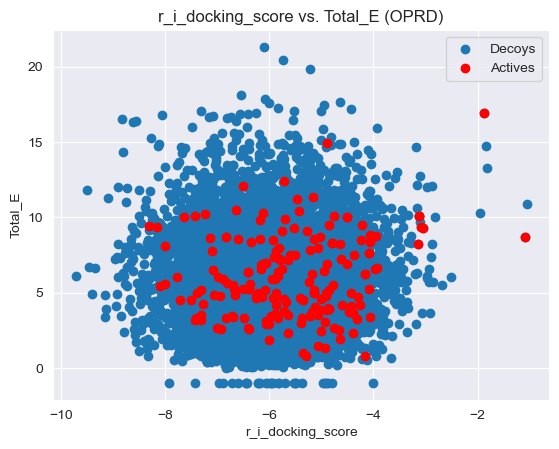

In [34]:
plt.scatter(all_data["r_i_docking_score"], all_data["Total_E"])
actives_all_data = all_data[all_data["Activity"] == 1]
plt.scatter(actives_all_data["r_i_docking_score"], actives_all_data["Total_E"], c="red")
plt.title(f"r_i_docking_score vs. Total_E ({title_suffix})")
plt.xlabel("r_i_docking_score")
plt.ylabel("Total_E")
plt.legend(["Decoys", "Actives"])
plt.show()

In [35]:
all_data_NegativeStrain=all_data[all_data["Total_E"] <= 0]
all_data_NegativeStrain

,Molecule_Name,Mol,Activity,s_m_source_file,i_m_source_file_index,i_lp_mmshare_version,i_f3d_flags,s_lp_Force_Field,r_lp_Energy,b_lp_Chiralities_Consistent,s_lp_Variant,s_i_glide_gridfile,i_i_glide_lignum,i_i_glide_rotatable_bonds,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_hbond,r_i_glide_metal,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_erotb,r_i_glide_esite,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum,r_i_glide_eff_state_penalty,Total_E,Lower_Bound,Upper_Bound,Num_Torsion_Patterns,Cumulative_Actives,Total_Actives,Fraction_Actives,Percentage_Screened
211,C43321561_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x290010120>,0,OPRD_chembl19_set_decoy_sc.smi,4807,53161,0,S-OPLS,19.0483,1,C43321561_Isomer1-1,OPRD,4805,5,-7.92880,-0.377562,-1.04167,-1.96038,-7.9288,-2.65305,-0.2,-0,-2.44106,-34.935,-10.5332,0.773762,-0.0817244,-71.37,-45.4682,6.71821,2,387,0,-1.0,0.0,0.0,1.0,5,185,0.027027,0.022678
569,C74815702_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x29009dcb0>,0,OPRD_chembl19_set_decoy_sc.smi,907,53161,0,S-OPLS,-10.9787,1,C74815702_Isomer1-1,OPRD,906,5,-7.41978,-0.370989,-1.00702,-1.85693,-7.41978,-1.22587,-0.738226,-0,-2.16401,-23.3964,-16.2392,0.611475,-0.297449,-62.9647,-39.6356,2.34907,22,167,0,-1.0,0.0,0.0,1.0,10,185,0.054054,0.061156
1310,C08695124_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x290bf1e70>,0,OPRD_chembl19_set_decoy_sc.smi,2725,53161,0,S-OPLS,40.0595,1,C08695124_Isomer1-1,OPRD,2723,8,-6.96367,-0.240127,-0.737745,-1.5945,-6.96367,-2.2746,-0.163102,-0,-1.05361,-49.5833,-9.95883,0.63611,-0.135475,-84.2862,-59.5421,13.0528,95,157,0,-1.0,0.0,0.0,1.0,24,185,0.129730,0.140800
1450,C11847167_Isomer2,<rdkit.Chem.rdchem.Mol object at 0x291635b60>,0,OPRD_chembl19_set_decoy_sc.smi,1710,53161,0,S-OPLS,25.7983,1,C11847167_Isomer2-1,OPRD,1709,7,-6.88697,-0.229566,-0.713314,-1.5648,-6.88697,-2.74844,-0.16,-0,-0.796638,-46.2464,-7.96438,0.606128,-0.281046,-71.6609,-54.2107,12.6107,81,322,0,-1.0,0.0,0.0,1.0,26,185,0.140541,0.155847
1923,C72490879_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x292806960>,0,OPRD_chembl19_set_decoy_sc.smi,3565,53161,0,S-OPLS,41.5228,1,C72490879_Isomer1-1,OPRD,3563,12,-6.70812,-0.268325,-0.784586,-1.59002,-6.70812,-2.09234,-0.843796,-0,-1.45303,-24.4233,-13.5711,1.22274,-0.284855,-52.6297,-37.9944,13.5719,108,183,0,-1.0,0.0,0.0,3.0,32,185,0.172973,0.206685
2253,C37615225_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x29288f760>,0,OPRD_chembl19_set_decoy_sc.smi,5880,53161,0,S-OPLS,21.3241,1,C37615225_Isomer1-1,OPRD,5878,6,-6.59671,-0.314129,-0.866658,-1.63102,-6.59671,-1.08533,-0.368357,-0,-2.01982,-29.3214,-12.2761,0.476202,-0.291915,-64.9643,-41.5975,2.9491,33,389,0,-1.0,0.0,0.0,3.0,38,185,0.205405,0.242154
2683,C37616621_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x29335f450>,0,OPRD_chembl19_set_decoy_sc.smi,1367,53161,0,S-OPLS,35.4743,1,C37616621_Isomer1-1,OPRD,1366,5,-6.45119,-0.322559,-0.875561,-1.61452,-6.45119,-0.916295,-0.471502,-0,-1.79967,-28.2088,-14.9926,0.824429,-0.428827,-66.4255,-43.2013,4.34085,144,353,0,-1.0,0.0,0.0,3.0,41,185,0.221622,0.288371
2701,C37033180_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x29335fbc0>,0,OPRD_chembl19_set_decoy_sc.smi,3974,53161,0,S-OPLS,29.8973,1,C37033180_Isomer1-1,OPRD,3972,5,-6.44365,-0.306841,-0.84655,-1.59318,-6.44365,-1.14957,-0.431631,-0,-1.79746,-31.6757,-12.763,0.760633,-0.327385,-69.6365,-44.4387,0.293074,8,327,0,-1.0,0.0,0.0,3.0,41,185,0.221622,0.290305
2773,C45137087_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x2933a1c40>,0,OPRD_chembl19_set_decoy_sc.smi,205,53161,0,S-OPLS,18.529,1,C45137087_Isomer1-1,OPRD,204,6,-6.41990,-0.305709,-0.843429,-1.58731,-6.4199,-1.39065,-0.266303,-0,-2.04313,-36.3196,-9.53463,0.889659,-0.363294,-62.04,-45.8543,6.75289,26,127,0,-1.0,0.0,0.0,1.0,41,185,0.221622,0.298044
3404,C49181651_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x293cb2dc0>,0,OPRD_chembl19_set_decoy_sc.s

In [36]:
# print Molecule_Name for all rows with Total_E <= 0
for index, row in all_data_NegativeStrain.iterrows():
    print(row['Molecule_Name'])

C43321561_Isomer1
C74815702_Isomer1
C08695124_Isomer1
C11847167_Isomer2
C72490879_Isomer1
C37615225_Isomer1
C37616621_Isomer1
C37033180_Isomer1
C45137087_Isomer1
C49181651_Isomer1
C37041198_Isomer1
C70087139_Isomer1
C16806680_Isomer1
C63180894_Isomer1
C40347693_Isomer1
C71323216_Isomer1
C10272074_Isomer1
C08798975_Isomer1
C12882208_Isomer1
C10043173_Isomer1
C50350881_Isomer1
C24749438_Isomer1
C48311214_Isomer1
C50351341_Isomer1
C36721901_Isomer1
C40166364_Isomer1
C69089691_Isomer1
C40166397_Isomer1
C32004965_Isomer1
C20213052_Isomer1


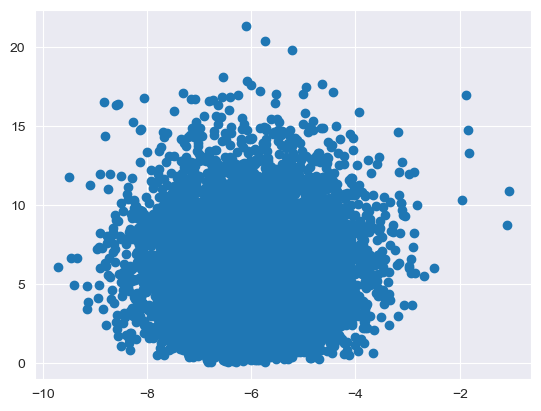

In [37]:
all_data_positive = all_data[all_data["Total_E"] >= 0]
plt.scatter(all_data_positive["r_i_docking_score"], all_data_positive["Total_E"])

In [38]:
from matplotlib.cm import viridis
from matplotlib.colors import Normalize

In [39]:
def identify_pareto(scores):
    population_size = scores.shape[0]
    pareto_front = np.ones(population_size, dtype=bool)
    for i in range(population_size):
        for j in range(population_size):
            if all(scores[j] <= scores[i]) and any(scores[j] < scores[i]):
                pareto_front[i] = 0
                break
    return np.where(pareto_front == 1)[0]


def find_pareto_ranks(scores, max_ranks=100):
    ranks = []
    remaining_scores = scores.copy()
    remaining_indices = np.arange(scores.shape[0])
    for _ in range(max_ranks):
        pareto_indices = identify_pareto(remaining_scores)
        ranks.append(remaining_indices[pareto_indices])
        remaining_scores = np.delete(remaining_scores, pareto_indices, axis=0)
        remaining_indices = np.delete(remaining_indices, pareto_indices)
        if remaining_scores.shape[0] == 0:
            break
    return ranks



In [40]:
data = all_data_positive

In [41]:
# Extract the scores for the entire dataset
scores = data[["r_i_docking_score", "Total_E"]].values

# Find the ranks of Pareto fronts until all points are classified or a max limit is reached
pareto_ranks_indices = find_pareto_ranks(
    scores, max_ranks=20
)  # Adjust max_ranks as needed

/var/folders/2c/b9b_8fbs13j5zcz4wv9bqqjm0000gn/T/ipykernel_74101/1624393553.py:34: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=np.linspace(0, num_ranks - 1, num_ranks))


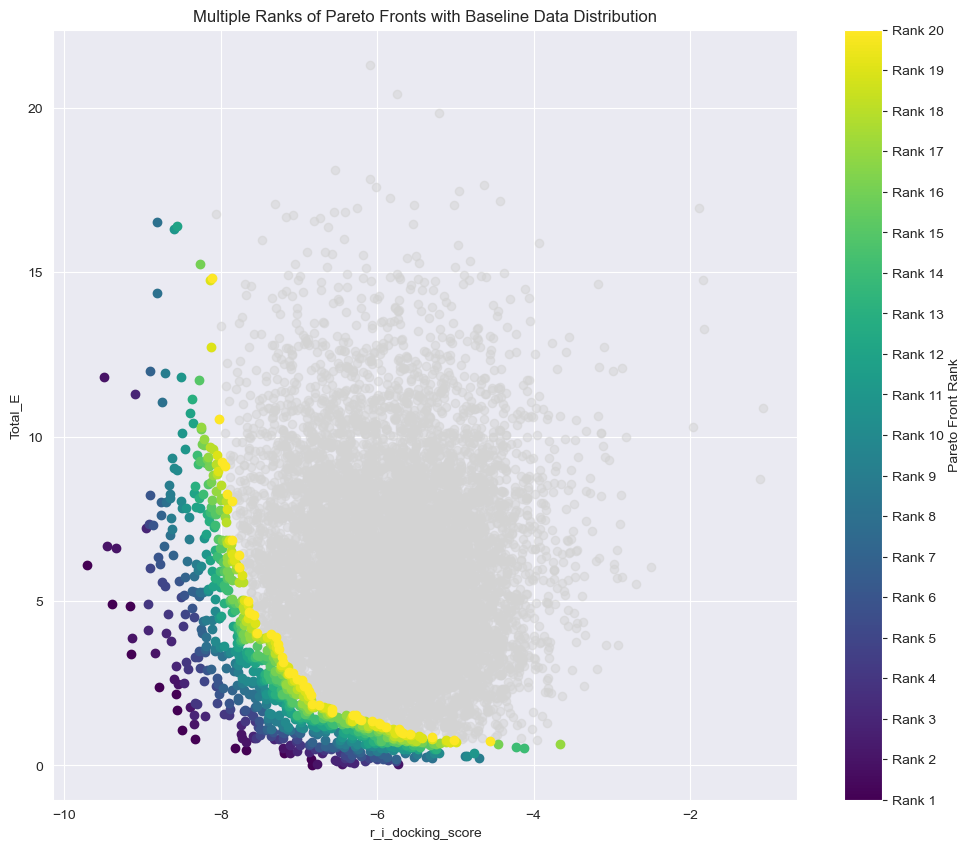

In [42]:
# Determine the actual number of ranks found
num_ranks = len(pareto_ranks_indices)

# Plot the baseline data distribution
plt.figure(figsize=(12, 10))
plt.scatter(
    data["r_i_docking_score"],
    data["Total_E"],
    color="lightgrey",
    label="Baseline Data",
    alpha=0.5,
)

# Generate colors for each rank dynamically using a colormap
colormap = viridis
norm = Normalize(vmin=0, vmax=num_ranks - 1)

for i, indices in enumerate(pareto_ranks_indices):
    rank_data = data.iloc[indices]
    plt.scatter(
        rank_data["r_i_docking_score"],
        rank_data["Total_E"],
        color=colormap(norm(i)),
        label=f"Rank {i+1}",
    )

plt.title("Multiple Ranks of Pareto Fronts with Baseline Data Distribution")
plt.xlabel("r_i_docking_score")
plt.ylabel("Total_E")

# Create a custom legend
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ticks=np.linspace(0, num_ranks - 1, num_ranks))
cbar.ax.set_yticklabels([f"Rank {i+1}" for i in range(num_ranks)])
cbar.set_label("Pareto Front Rank")

plt.grid(True)
plt.show()

In [43]:
# Count the number of Pareto points per rank and the total
num_points_per_rank = [len(indices) for indices in pareto_ranks_indices]
total_points = sum(num_points_per_rank)

# Print the counts
print("Number of Pareto points per rank:")
for rank, count in enumerate(num_points_per_rank, start=1):
    print(f"Rank {rank}: {count} points")

print(f"\nTotal Pareto points across all ranks: {total_points}")

Number of Pareto points per rank:
Rank 1: 15 points
Rank 2: 17 points
Rank 3: 22 points
Rank 4: 20 points
Rank 5: 33 points
Rank 6: 33 points
Rank 7: 31 points
Rank 8: 41 points
Rank 9: 41 points
Rank 10: 41 points
Rank 11: 44 points
Rank 12: 52 points
Rank 13: 46 points
Rank 14: 54 points
Rank 15: 58 points
Rank 16: 58 points
Rank 17: 50 points
Rank 18: 48 points
Rank 19: 53 points
Rank 20: 50 points

Total Pareto points across all ranks: 807


In [44]:
all_pareto_ranks_indices = np.concatenate(pareto_ranks_indices)
display(data.iloc[all_pareto_ranks_indices])

,Molecule_Name,Mol,Activity,s_m_source_file,i_m_source_file_index,i_lp_mmshare_version,i_f3d_flags,s_lp_Force_Field,r_lp_Energy,b_lp_Chiralities_Consistent,s_lp_Variant,s_i_glide_gridfile,i_i_glide_lignum,i_i_glide_rotatable_bonds,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_hbond,r_i_glide_metal,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_erotb,r_i_glide_esite,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum,r_i_glide_eff_state_penalty,Total_E,Lower_Bound,Upper_Bound,Num_Torsion_Patterns,Cumulative_Actives,Total_Actives,Fraction_Actives,Percentage_Screened
1,C39933632_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x176c2e650>,0,OPRD_chembl19_set_decoy_sc.smi,2097,53161,0,S-OPLS,59.2362,1,C39933632_Isomer1-1,OPRD,2096,6,-9.71214,-0.303504,-0.963567,-2.17481,-9.71214,-3.40649,-0.339259,-0,-2.16181,-43.9798,-12.072,0.426867,-0.221657,-92.6984,-56.0518,9.16763,118,350,0,6.083277,4.752726,NaN,2.0,0,185,0.000000,0.000107
4,C39915953_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x176c2e880>,0,OPRD_chembl19_set_decoy_sc.smi,7805,53161,0,S-OPLS,43.2058,1,C39915953_Isomer1-1,OPRD,7802,10,-9.39112,-0.276209,-0.894811,-2.07476,-9.39112,-3.15139,-0.240971,-0,-1.24306,-38.7002,-19.5618,0.335635,-0.222046,-94.125,-58.262,6.52834,80,241,0,4.919639,4.081011,6.779628,3.0,0,185,0.000000,0.000430
6,C55146530_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x176c2e8f0>,0,OPRD_chembl19_set_decoy_sc.smi,8950,53161,0,S-OPLS,75.7444,1,C55146530_Isomer1-1,OPRD,8947,4,-9.15704,-0.339149,-1.01745,-2.13161,-9.15704,-2.29698,-0.645506,-0,-1.30341,-29.4011,-23.7853,0.320827,-0.194122,-84.8933,-53.1863,1.05643,2,98,0,4.861070,4.002536,NaN,1.0,0,185,0.000000,0.000645
7,C19541020_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x176c2eab0>,0,OPRD_chembl19_set_decoy_sc.smi,82,53161,0,S-OPLS,47.4021,1,C19541020_Isomer1-1,OPRD,81,5,-9.14370,-0.365748,-1.06945,-2.16733,-9.1437,-3.07777,-0.498099,-0,-2.17486,-40.8126,-10.1987,0.298172,-0.120705,-82.4083,-51.0113,3.17779,7,380,0,3.398507,2.908242,4.281516,3.0,0,185,0.000000,0.000752
22,C63172484_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x176c2eea0>,0,OPRD_chembl19_set_decoy_sc.smi,3677,53161,0,S-OPLS,25.3574,1,C63172484_Isomer1-1,OPRD,3675,3,-8.79369,-0.439684,-1.19349,-2.20077,-8.79369,-2.1162,-0.358097,-0,-3.66818,-29.8667,-9.88412,0.440939,-0.116201,-69.8171,-39.7508,1.08407,27,247,0,2.388497,2.193888,2.619384,2.0,0,185,0.000000,0.002365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5430,C43576543_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x29656da10>,0,OPRD_chembl19_set_decoy_sc.smi,5456,53161,0,S-OPLS,33.0548,1,C43576543_Isomer1-1,OPRD,5454,2,-5.67089,-0.270042,-0.745026,-1.40212,-5.67089,-1.30102,-0.2,-0,-1.46165,-30.0144,-8.69405,0.276903,-0.18029,-55.5372,-38.7084,0.902468,2,184,0,0.980249,0.599768,1.782518,0.0,93,185,0.502703,0.583620
5780,C54556889_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x2965f7300>,0,OPRD_chembl19_set_decoy_sc.smi,3412,53161,0,S-OPLS,15.9072,1,C54556889_Isomer1-1,OPRD,3410,2,-5.58575,-0.328573,-0.844854,-1.4572,-5.58575,-1.1111,-0.196811,-0,-1.98659,-21.9566,-9.13818,0.277309,-0.1,-46.4104,-31.0948,0.259566,3,40,0,0.945957,0.874293,1.023612,0.0,97,185,0.524324,0.621238
6805,C20100517_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x297ad7220>,0,OPRD_chembl19_set_decoy_sc.smi,8652,53161,0,S-OPLS,52.8991,1,C20100517_Isomer1-1,OPRD,8649,1,-5.29721,-0.211888,-0.619565,-1.2556,-5.29721,-0.509525,-0.476256,-0,-1.94127,-27.7666,-6.42888,0.108636,-0.12613,-49.128,-34.1955,1.06309,3,268,0,0.852388,0.504144,1.795562,0.0,108,185,0.583784,0.731406
7677,C70711288_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x29976eab0>,0,OPRD_chembl19_set_decoy_sc.smi,2563,53161,0,S-OPLS,42.4948,1,C70711288_Isomer1-1,OPRD,2561,2,-5.01595,-0.313497,-0.789963,-1.32958,-5.

In [45]:
pareto_front_df = data.iloc[all_pareto_ranks_indices]

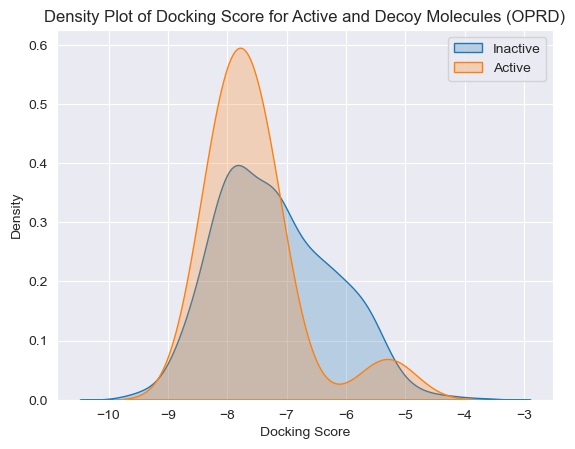

In [46]:
plot_density(pareto_front_df, title_suffix)

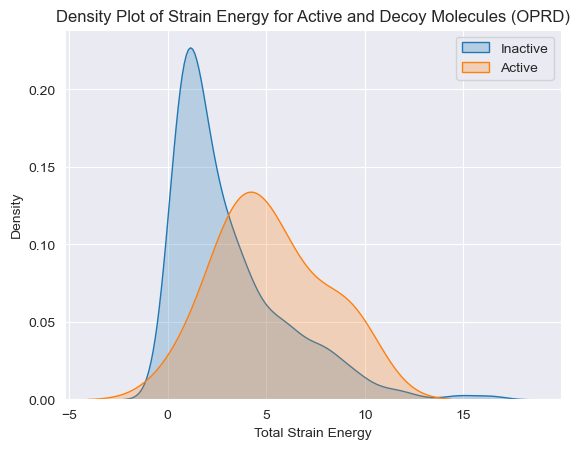

In [47]:
plot_density_strain(pareto_front_df, title_suffix)

In [48]:
pareto_front_df = calculate_enrichment_parameters(pareto_front_df)

In [49]:
def plot_enrichment_curve_classifier(df, title_suffix):
    """
    Plots the enrichment curve for a dataframe, including the performance of a random classifier.

    Parameters:
    df (pandas.DataFrame): The dataframe to plot the enrichment curve for.
    title_suffix (str): The suffix to add to the title of the plot.

    Returns:
    None
    """
    # Calculate the Enrichment AUC
    enrichment_auc = auc(df["Percentage_Screened"], df["Fraction_Actives"])

    # Calculate the enrichment at the closest value to 1%
    # Subtract 0.01 (1%) from the 'Percentage_Screened' column and find the absolute value
    # (df['Percentage_Screened'] - 0.01).abs()
    # Sort the resulting series and take the first index (smallest difference)
    # (df['Percentage_Screened'] - 0.01).abs().argsort()[:1]
    # Use the index to get the row from the dataframe
    closest_to_one_percent = df.iloc[
        (df["Percentage_Screened"] - 0.01).abs().argsort()[:1]
    ]
    # df["Some_Column"].values[0] gets the value of the first row of "Some_Column"
    # It would return a pd.Series without: .values[0]
    enrichment_at_one_percent = (
        closest_to_one_percent["Cumulative_Actives"].values[0]
        / closest_to_one_percent["Total_Actives"].values[0]
    )

    closest_to_five_percent = df.iloc[
        (df["Percentage_Screened"] - 0.05).abs().argsort()[:1]
    ]
    # df["Some_Column"].values[0] gets the value of the first row of "Some_Column"
    # It would return a pd.Series without: .values[0]
    enrichment_at_five_percent = (
        closest_to_five_percent["Cumulative_Actives"].values[0]
        / closest_to_five_percent["Total_Actives"].values[0]
    )

    # Plot the enrichment curve
    plt.plot(
        df["Percentage_Screened"] * 100,
        df["Fraction_Actives"] * 100,
        label="Enrichment AUC = {:.2f}\n(EF1% = {:.1f}%)\n(EF5% = {:.0f}%)".format(
            enrichment_auc,
            enrichment_at_one_percent * 100,
            enrichment_at_five_percent * 100,
        ),
    )

    #   # Plot the enrichment at 1%
    #   plt.scatter(
    #   1,
    #   enrichment_at_one_percent * 100,
    #   s=0,
    #   color='black',
    #   label="Enrichment (%) at 1% = {:.2f}".format(enrichment_at_one_percent*100),
    # )

    # Calculate and plot the performance of a random classifier
    overall_fraction_actives = df["Fraction_Actives"].iloc[
        -1
    ]  # Assuming the last point represents the overall fraction
    plt.plot(
        [0, 100],
        [0, overall_fraction_actives * 100],
        label="Random Classifier",
        linestyle="--",
        color="grey",
    )

    # Add axis labels and title
    plt.xlabel("Compounds Screened (%)")
    plt.ylabel("Percent of Identified Actives (%)")
    plt.title(f"Enrichment Curve ({title_suffix})")

    plt.legend()
    plt.show()


In [50]:
threshold4 = all_data[all_data["Total_E"] <= 4]
threshold4 = calculate_enrichment_parameters(threshold4)

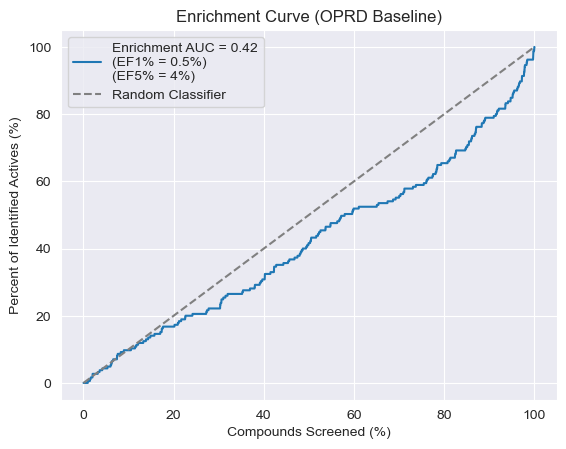

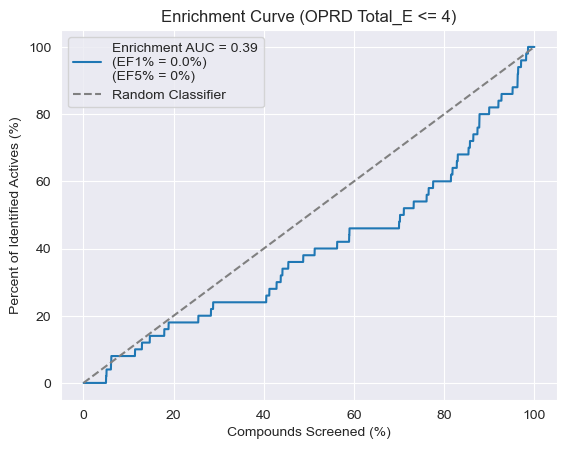

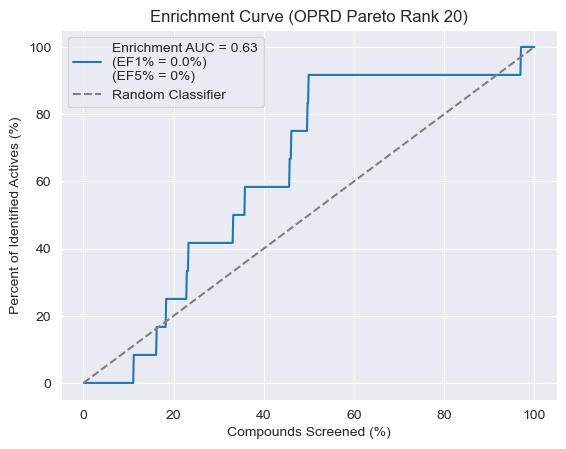

In [51]:
title_suffix_baseline = title_suffix + " Baseline"
title_suffix_threshold = title_suffix + " Total_E <= 4"
title_suffix_pareto = title_suffix + " Pareto Rank 20"
plot_enrichment_curve_classifier(all_data, title_suffix_baseline)
plot_enrichment_curve_classifier(threshold4, title_suffix_threshold)
plot_enrichment_curve_classifier(pareto_front_df, title_suffix_pareto)